# Part 1
Training the neural network

In [30]:
import typing as tp

import scipy
from matplotlib.image import imread
from matplotlib import pyplot as plt
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
import os
import sklearn
from tqdm import tqdm
from torch import nn, Tensor
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import random
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

torch.manual_seed(42)
random.seed(42)

In [2]:
is_kaggle = False  # I attempted to do training on kaggle kernel, but they did not have tensorboard support
# Combining with the fact that training there was only 3 times faster, I decided against it.
dataset_dir = "/local/tmp/BostonGene_application_data/images/" if not is_kaggle else "../input/bg-application/images"
models_dir = "/local/tmp/BostonGene_application_models/" if not is_kaggle else None
number_of_cpu_cores = 8 if not is_kaggle else 2
processed_image_size = 64
device = "cuda"
plt_figsize = (10, 10)

In [3]:
# Let's check, whether the classes are balanced
{target: len(os.listdir(f"{dataset_dir}/{target}")) for target in os.listdir(dataset_dir)}

{'ArtDeco': 65,
 'Naturalism': 218,
 'Impressionism': 240,
 'Japonism': 203,
 'photo': 139,
 'Cubism': 365,
 'Rococo': 117,
 'cartoon': 75}

They aren't, but imbalance is not particularly high.

Let's start by writing a wrapper class for our dataset.

In [4]:
class MyDataset(torch.utils.data.Dataset):
    NUMBER_OF_CLASSES = 8

    def __init__(self, dataset_dir: str, image_size: int = 64, train: bool = True, manual_ids: tp.Optional[bool] = None,
                 augmentations=None):
        """
        A wrapper class for our dataset.

        Since our dataset is small, we simply store it in RAM.

        :param dataset_dir: location of the upacked dataset
        :param image_size: size, to which the image will be resized during preprocessing
        :param train: set True for train, or False for test
        :param manual_ids: override default train\test ids split by manually choosing which ids to load. Ids should be chosen from MyDataset.get_ids()
        :param augmentations:
        """
        super().__init__()
        self._train = train
        self.target_names = os.listdir(dataset_dir)
        self.target_encoding = {self.target_names[_id]: _id for _id in range(len(self.target_names))}

        targets_and_filenames = [(target, filename) for target in self.target_names for filename in
                                 os.listdir(f"{dataset_dir}/{target}")]

        if manual_ids is None:
            targets = [self.target_encoding[item[0]] for item in targets_and_filenames]
            train_ids, test_ids = train_test_split(list(range(len(targets_and_filenames))), random_state=42,
                                                   test_size=0.1, shuffle=True,
                                                   stratify=targets)  # Classes are not balanced, so we must choose to stratify
            ids = train_ids if self._train else test_ids
        else:
            ids = manual_ids

        # Implementing augmentations
        if self._train and augmentations is not None:
            self.is_augmented = True
            preprocessing_pipeline = transforms.Compose([
                transforms.Lambda(lambda img: img / 255),  # Normalize
            ])
            self.augmentation_pipeline = transforms.Compose([  # Random augmentations are performed during training
                augmentations,
                transforms.Lambda(lambda img: transforms.RandomCrop(size=min(img.shape[1:]))(img)),  # Randomly crop to square
                transforms.Resize(size=image_size)
            ])
        else:
            self.is_augmented = False
            preprocessing_pipeline = transforms.Compose([
                transforms.Lambda(lambda img: img / 255),  # Normalize
                transforms.Lambda(lambda img: transforms.CenterCrop(size=min(img.shape[1:]))(img)),  # Crop to square
                transforms.Resize(size=image_size)
            ])

        self._data = []
        self._targets = []
        for target, file in np.array(targets_and_filenames)[ids]:
            self._data.append(preprocessing_pipeline(
                torch.tensor(imread(f"{dataset_dir}/{target}/{file}"), dtype=torch.float32).permute(2, 1, 0)))
            self._targets.append(self.target_encoding[target])

    def __len__(self):
        return len(self._targets)

    def __getitem__(self, item):
        img = self.augmentation_pipeline(self._data[item]) if self.is_augmented else self._data[item]
        return img, self._targets[item]

    @staticmethod
    def get_ids(dataset_dir: str):
        return list(range(sum([len(os.listdir(f"{dataset_dir}/{target}")) for target in os.listdir(f"{dataset_dir}")])))

    @staticmethod
    def target_decoding(dataset_dir):
        targets = os.listdir(dataset_dir)
        return {_id: targets[_id] for _id in range(len(targets))}


In [159]:
train_dataset = MyDataset(dataset_dir, processed_image_size, train=True,
                          augmentations=transforms.Compose([        # In order to prevent overfitting, I added these augmentations to the training data
                              transforms.RandomRotation(10),
                              transforms.RandomHorizontalFlip(p=0.1),
                              transforms.RandomVerticalFlip(p=0.1)
                          ])
                          )
test_dataset = MyDataset(dataset_dir, processed_image_size, train=False)

Here we can see an example of preprocessed and augmented image.

Before:


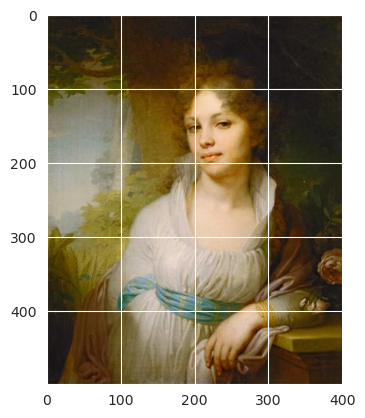

After:


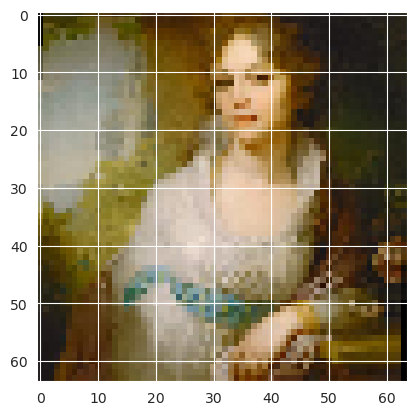

In [161]:
img_id = 1
print("Before:")
plt.imshow(train_dataset._data[img_id].permute(2, 1, 0))
plt.show()
print("After:")
plt.imshow(train_dataset[img_id][0].permute(2, 1, 0))
plt.show()

Note: since I won't perform a hyperparameters optimization, a simple train/test split will suffice (instead of train/val/test split).

In retrospect, perhaps, optimising for the architecture and augmentations might lead to improved performance, but, unfortunately, I do not have time or computational resources for it.

Let's create a simple baseline - a ResNet model.

I believe, that this is a right architecture to choose, because it is a convolution neural network, which does not suffer from vanishing gradients.

And CNNs in general are the best architecture to solve image classification.

(Of course, on big datasets like ImageNet transformers outperform CNNs, but they require a lot of data and computational resources, which we don't have)

In [7]:
class ResBlock(nn.Module):
    """
    A building block for MyResNet model
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.downsample = False
        if in_channels != out_channels:
            self.downsample = True
            self.downsample_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                              kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, _input: Tensor) -> Tensor:
        identity = _input
        if self.downsample:
            identity = self.downsample_layer(identity)

        output = self.conv1(_input)
        output = self.bn1(output)
        output = self.activation(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output += identity
        output = self.activation(output)

        return output


class MyResNet(nn.Module):
    """
    My ResNet model implementation
    """
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, input_channels: int, layers: list[tuple[int, int]], num_of_classes: int, initial_layers:
    tp.Optional[nn.Module] = None):
        """

        :param input_channels:
        :param layers:
        :param num_of_classes:
        :param initial_layers:
        """
        super().__init__()

        if initial_layers is None:
            initial_layers = nn.Identity()
        self.initial_layers = initial_layers

        self.layers = nn.Sequential()
        for layer_id, layer in enumerate(layers):
            num_of_blocks, channels_per_block = layer
            for block_id in range(num_of_blocks):
                if block_id == 0:
                    if layer_id == 0:
                        in_channels = input_channels
                    else:
                        in_channels = layers[layer_id - 1][1]
                else:
                    in_channels = channels_per_block
                self.layers.add_module(f"ResBlock{layer_id}_{block_id}",
                                       ResBlock(in_channels=in_channels, out_channels=channels_per_block))

            if layer_id != len(layers) - 1:
                self.layers.add_module(f"pool{layer_id}", nn.MaxPool2d(2))

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=layers[-1][1], out_features=num_of_classes)

    def forward(self, _input: Tensor) -> Tensor:
        output = self.initial_layers(_input)
        output = self.layers(output)
        output = self.avg_pool(output)
        output = torch.flatten(output, 1)
        output = self.fc(output)

        return output

Here I write the code used for training.

Because training my model took 8 to 10 hours, I decided against cross-validation in favor of a simple train\test split.

For training, I chose a cross-entropy loss, because it is a go-to loss for multiclass classification.

For validation and evaluation on test, I chose accuracy and macro-averaged and weighted averaged f1-scores. Accuracy will be used to evaluate the model's performance, and comparing macro-averaged f1-score with weighted-averaged f1-score can show whether the model discriminates against smaller classes.

Plotting of metrics values vs epoch number is done using tensorboard.

In [7]:
def trainer(number_of_epochs,
            dataset,
            val_dataset,
            batch_size,
            model,
            loss_function,
            optimizer,
            writer,
            experiment_dir,
            lr=0.001,
            lr_multiplier_schedule=None,
            writer_start_iteration_offset=0):
    def make_val_report(iteration):
        report = calculate_val_performance(model, DataLoader(val_dataset, batch_size=1, shuffle=False,
                                                             num_workers=number_of_cpu_cores))

        def report_avg(which_avg):
            for metric in report[which_avg]:
                if metric != 'support':
                    writer.add_scalar(f'metrics/{which_avg}/{metric}', report[which_avg][metric],
                                      iteration + writer_start_iteration_offset)

        report_avg('weighted avg')
        report_avg('macro avg')
        writer.add_scalar(f'metrics/accuracy', report['accuracy'], iteration + writer_start_iteration_offset)
        return report['accuracy']

    optima = optimizer(model.parameters(), lr=lr)

    best_val_metrics = 0
    Path(f"{experiment_dir}").mkdir(mode=774, exist_ok=True)
    Path(f"{experiment_dir}/checkpoints").mkdir(mode=774, exist_ok=True)

    iterations = tqdm(range(number_of_epochs), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        if lr_multiplier_schedule is not None and it in lr_multiplier_schedule:
            lr *= lr_multiplier_schedule[it]
            optima = optimizer(model.parameters(), lr=lr)

        epoch_loss = train_epoch(
            train_generator=DataLoader(dataset, batch_size, shuffle=True, num_workers=number_of_cpu_cores),
            model=model,
            loss_function=loss_function,
            optimizer=optima)

        iterations.set_postfix({'train epoch loss': epoch_loss})
        writer.add_scalar('metrics/train_loss', epoch_loss, it + writer_start_iteration_offset)
        writer.add_scalar('lr/train_loss', lr, it + writer_start_iteration_offset)
        val_metrics = make_val_report(it)
        if val_metrics >= best_val_metrics:
            torch.save(model, f"{experiment_dir}/checkpoints/best.pth")
            best_val_metrics = val_metrics

        torch.save(model, f"{experiment_dir}/checkpoints/last.pth")


def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()

    epoch_loss = 0
    total = 0
    for x, y in train_generator:
        optimizer.zero_grad()

        output = model(x.to(model.device))

        loss = loss_function(output, y.to(model.device))
        loss.backward()

        optimizer.step()

        epoch_loss += loss.cpu().item()
        total += 1

    return epoch_loss / total


def calculate_val_performance(model, val_dataset):
    model.eval()

    # y_pred_scores = [model(x.to(model.device)).cpu() for x, y in val_dataset]
    # y_pred = [int(torch.argmax(scores)) for scores in y_pred_scores]
    y_pred = [int(torch.argmax(model(x.to(model.device)).cpu())) for x, y in val_dataset]
    y_target = [int(y) for x, y in val_dataset]
    # "top3accuracy": sklearn.metrics.top_k_accuracy_score(),
    return {**sklearn.metrics.classification_report(y_target, y_pred, output_dict=True, zero_division=0)}


Finally, let's do some training!

In [8]:
# Here I have trained two models:

# model = MyResNet(input_channels=3, layers=[(4, 64), (4, 128)], num_of_classes=8)  #resnet_v0.2
# model = MyResNet(input_channels=3, layers=[(4, 64), (6, 128), (4, 256)], num_of_classes=8)  #resnet_v0.3_long (bigger networks don't fit inside my GPU memory ><)

In [10]:
# model.to('cuda')
# trainer(number_of_epochs=400,
#         dataset=train_dataset,
#         val_dataset=test_dataset,
#         batch_size=16,
#         model=model,
#         loss_function=nn.CrossEntropyLoss(),
#         optimizer=torch.optim.Adam,
#         writer=SummaryWriter(log_dir='/local/tmp/logs/BG_application/resnet_v0.3_long'),
#         experiment_dir="/local/tmp/experiments/resnet_v0.3_long",
#         lr=0.001,
#         writer_start_iteration_offset=0)

Let's assess the model's performance:

In [156]:
model = torch.load("/local/tmp/experiments/resnet_v0.2/checkpoints/last.pth")
calculate_val_performance(model, val_dataset=tqdm(DataLoader(dataset=test_dataset, batch_size=1)))

100%|██████████| 143/143 [00:10<00:00, 13.94it/s]


{'0': {'precision': 0.4,
  'recall': 0.6666666666666666,
  'f1-score': 0.5,
  'support': 6},
 '1': {'precision': 0.875,
  'recall': 0.6363636363636364,
  'f1-score': 0.7368421052631579,
  'support': 22},
 '2': {'precision': 0.5333333333333333,
  'recall': 0.6666666666666666,
  'f1-score': 0.5925925925925926,
  'support': 24},
 '3': {'precision': 0.75,
  'recall': 0.6,
  'f1-score': 0.6666666666666665,
  'support': 20},
 '4': {'precision': 0.5333333333333333,
  'recall': 0.5714285714285714,
  'f1-score': 0.5517241379310344,
  'support': 14},
 '5': {'precision': 0.7272727272727273,
  'recall': 0.6486486486486487,
  'f1-score': 0.6857142857142857,
  'support': 37},
 '6': {'precision': 0.8181818181818182,
  'recall': 0.75,
  'f1-score': 0.7826086956521738,
  'support': 12},
 '7': {'precision': 0.3333333333333333,
  'recall': 0.5,
  'f1-score': 0.4,
  'support': 8},
 'accuracy': 0.6363636363636364,
 'macro avg': {'precision': 0.6213068181818182,
  'recall': 0.6299717737217737,
  'f1-score':

In [155]:
model = torch.load("/local/tmp/experiments/resnet_v0.3_long/checkpoints/last.pth")
calculate_val_performance(model, val_dataset=tqdm(DataLoader(dataset=test_dataset, batch_size=1)))

100%|██████████| 143/143 [00:18<00:00,  7.75it/s]


{'0': {'precision': 1.0,
  'recall': 0.3333333333333333,
  'f1-score': 0.5,
  'support': 6},
 '1': {'precision': 0.4722222222222222,
  'recall': 0.7727272727272727,
  'f1-score': 0.5862068965517242,
  'support': 22},
 '2': {'precision': 0.5652173913043478,
  'recall': 0.5416666666666666,
  'f1-score': 0.5531914893617021,
  'support': 24},
 '3': {'precision': 0.7142857142857143,
  'recall': 0.5,
  'f1-score': 0.588235294117647,
  'support': 20},
 '4': {'precision': 0.47368421052631576,
  'recall': 0.6428571428571429,
  'f1-score': 0.5454545454545454,
  'support': 14},
 '5': {'precision': 0.75,
  'recall': 0.6486486486486487,
  'f1-score': 0.6956521739130435,
  'support': 37},
 '6': {'precision': 0.4,
  'recall': 0.3333333333333333,
  'f1-score': 0.3636363636363636,
  'support': 12},
 '7': {'precision': 0.7142857142857143,
  'recall': 0.625,
  'f1-score': 0.6666666666666666,
  'support': 8},
 'accuracy': 0.5874125874125874,
 'macro avg': {'precision': 0.6362119065780393,
  'recall': 0.54

Let's also look at the evolution of the metrics during training

Img 1: accuracy on test dataset during training:

![](images/accuracy.png)


Img 2: cross-entropy loss on training dataset during training:

![](images/train_loss.png)

Img 3 and 4: f1-scores:

![](images/macro_f1.png)
![](images/weighted_f1.png)


It appears, that the model converges, however, values of metrics on the test dataset fluctuate within a wide range (0.55-0.65 for accuracy).

It appears, there are no difference between the two models.

And if we compare macro-averaged f1 score (fluctuates roughly within range 0.5-0.6) with weighted averaged f1 score (fluctuates roughly within range 0.55-0.65) we can see that model slightly discriminates against small classes.

Maybe, this discrimination can be corrected if we use a weighted loss function. (but I don't have time to redo training).


In [ ]:
# You can use tensorboard to look at the plots yourself:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

# Part 2
Using output of the last hidden layer as a feature vector

In [8]:
# Let's extract our feature vectors

# Here I should make sure to not use the best.pth checkpoint, as it will result in peeking into the test dataset
model = torch.load("/local/tmp/experiments/resnet_v0.2/checkpoints/last.pth", 'cpu')
model.fc = nn.Identity()
model.to('cpu')
model.eval()
pass

In [9]:
with torch.no_grad():
    train_dataset = [(model(x[None, ...]).numpy()[0], y) for x, y in
                     tqdm(MyDataset(dataset_dir, processed_image_size, train=True))]
    test_dataset = [(model(x[None, ...]).numpy()[0], y) for x, y in
                    tqdm(MyDataset(dataset_dir, processed_image_size, train=False))]

train_data = np.array([x for x, y in train_dataset])
train_targets = np.array([y for x, y in train_dataset])
test_data = np.array([x for x, y in test_dataset])
test_targets = np.array([y for x, y in test_dataset])

100%|██████████| 143/143 [00:04<00:00, 32.01it/s]


In [143]:
# Let's perform clustering using t-sne for train and test data

colors = ["red", "blue", "green", "yellow", "cyan", "purple", "orange", "grey"]

def tsne_plot_helper(embedded_data, targets, tag, marker, alpha=0.8):
    for target_id in range(MyDataset.NUMBER_OF_CLASSES):
        plt.scatter(embedded_data[:, 0][targets == target_id], embedded_data[:, 1][targets == target_id],
                    c=colors[target_id], label=MyDataset.target_decoding(dataset_dir)[target_id] + tag, marker=marker,
                    alpha=alpha)

#
# def plot_tsne(data, targets, tag):
#     plt.figure(figsize=plt_figsize)
#     embedded_data = TSNE(init="random", learning_rate=200).fit_transform(data)
#     tsne_plot_helper(embedded_data, targets, tag, 'o')
#     plt.title(tag)
#     plt.legend()
#     plt.show()
#
# plot_tsne(train_data, train_targets, "_train")
# plot_tsne(test_data, test_targets, "_test")

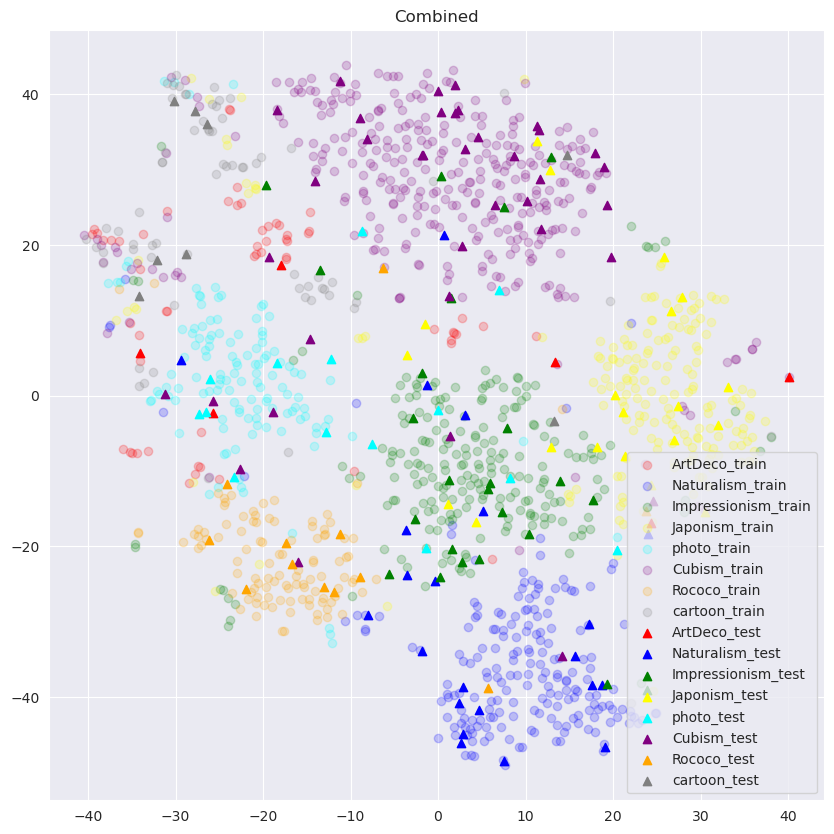

In [144]:
plt.figure(figsize=plt_figsize)
embedded_data = TSNE(init="random", learning_rate=200).fit_transform(np.vstack((train_data, test_data)))

tsne_plot_helper(embedded_data[:len(train_dataset)], train_targets, "_train", 'o', alpha=0.2)
tsne_plot_helper(embedded_data[len(train_dataset):], test_targets, "_test", '^', alpha=1)
plt.title("Combined")
plt.legend()
plt.show()

At the first glance the clusters look almost separable, with a few outliers for each class.

The toughest to cluster are the classes with the lowest amount of objects (ArtDeco and cartoon). Perhaps, training neural network with weighted loss to counteract this imbalance could lead to performance improvement.

Also, it feels like clusters of test data have a bit higher proportion of outliers than clusters of train data.

Despite the beauty of t-sne clustering, it is hard to interpret which features are the most important to distinguishing these clusters.
In order to gain some insight into this question, a more interpretable clustering algorithm should be used.

In reality, I could not come up off the top of my head with a clustering algorithm, that would report the "importance" of the features.

Hence, I came up with a different solution:

The task asks to find features, that differentiate the clusters.

Since our t-sne clusters match target labels pretty good, I decided to use target labels in the further analysis of which features are the most important for separability of the clusters.

Idea:

I will use a p_value from a non-parametric statistical test that tests for the equality of the distributions of the values of each feature across all target classes (a Kruskal-Wallis H-test) as a proxy for how important that feature is to distinguishing the classes (the lower the p-value, the better this feature distinguishes at least one target class from the others).

I have chosen this statistical test, because it is non-parametric (and we don't have any prior knowledge about distributions of our features) and because it allows for comparing more than two feature distributions at once.


In [84]:
data = np.vstack((train_data, test_data))
targets = np.hstack((train_targets,  test_targets))
# data = test_data
# targets = test_targets
number_of_features = len(data[0])
means = []
stds = []
for target in range(MyDataset.NUMBER_OF_CLASSES):
    means.append(np.mean(data[targets == target], axis=0))
    stds.append(np.std(data[targets == target], axis=0))

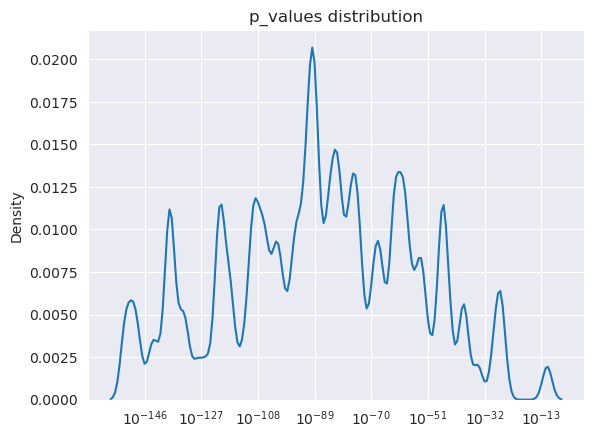

In [87]:

p_values = []
for feature_id in range(number_of_features):
    samples = [data[:,feature_id][targets == target] for target in range(MyDataset.NUMBER_OF_CLASSES)]
    p_values.append(scipy.stats.kruskal(*samples)[1])
p_values = np.array(p_values)
sns.kdeplot(p_values, log_scale=True, bw_method=0.05)
plt.title("p_values distribution")
plt.show()

All p-values turned out to be really low. That means, that there are no useless features produced by the last hidden layer of the neural network.

However, we still can get a "top-10" of useful features:

In [91]:
[{"feature": feature, "p_value": p_values[feature]} for feature in np.argsort(p_values)[:10]]

[{'feature': 26, 'p_value': 2.3192514897131257e-153},
 {'feature': 79, 'p_value': 3.629766315371527e-153},
 {'feature': 50, 'p_value': 6.142974632886558e-151},
 {'feature': 84, 'p_value': 2.880722962467441e-150},
 {'feature': 95, 'p_value': 1.0351533950922666e-148},
 {'feature': 16, 'p_value': 1.1324920300663758e-144},
 {'feature': 121, 'p_value': 6.00532782483684e-143},
 {'feature': 29, 'p_value': 7.157426235765389e-140},
 {'feature': 120, 'p_value': 2.407960212055321e-138},
 {'feature': 111, 'p_value': 3.015968443545319e-138}]

If we actually draw the distributions of these features for each target class, we can see, that they separate the classes better, than, for example, 5 worst features:

In [ ]:
def plot_feature_distributions(features):
    for feature_id in features:
        for target in range(MyDataset.NUMBER_OF_CLASSES):
            # plt.hist(data[:,feature_id][targets == target], label=target, alpha=0.1)
            sns.kdeplot(data[:,feature_id][targets == target], label=target)
        plt.legend()
        plt.title(f"{feature_id} : {p_values[feature_id]:.0e}")
        plt.xlim((0,2))
        plt.show()

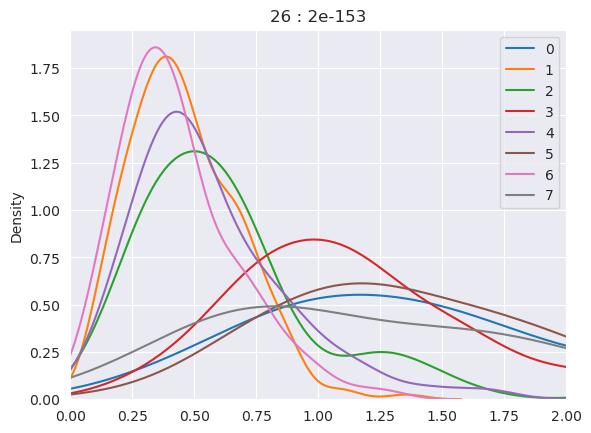

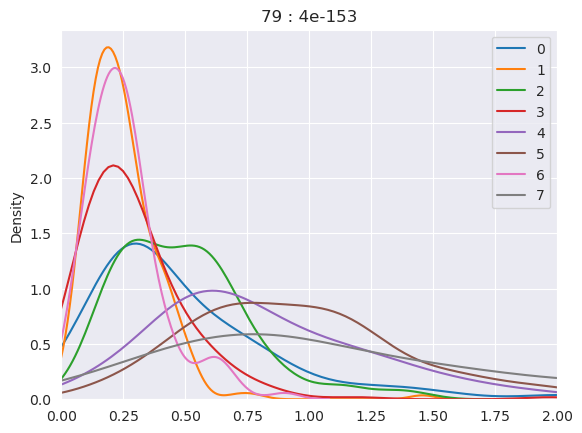

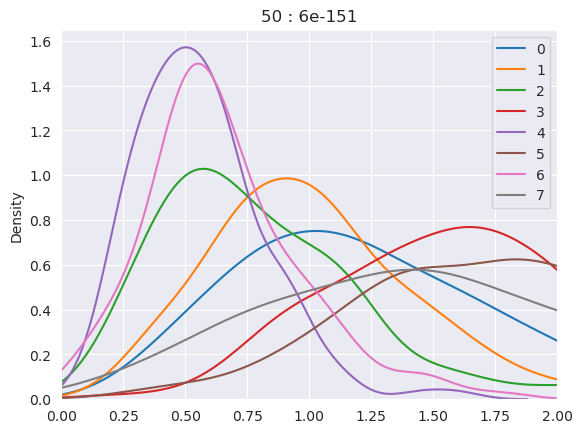

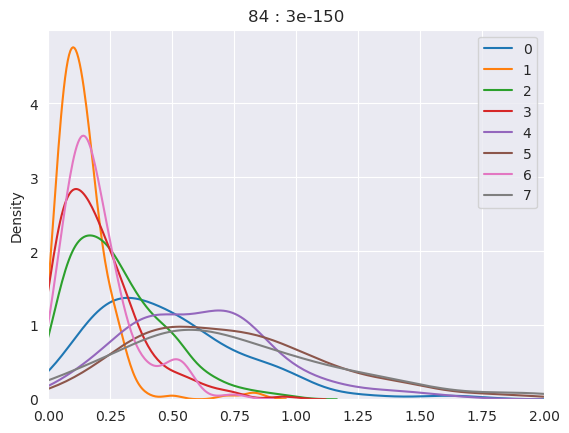

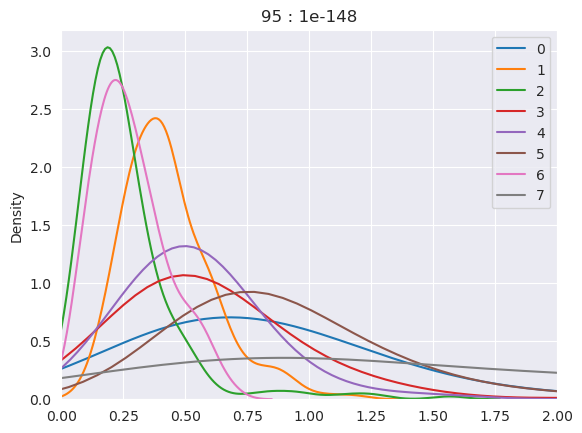

In [94]:
# Top-5 features:
plot_feature_distributions(np.argsort(p_values)[:5])

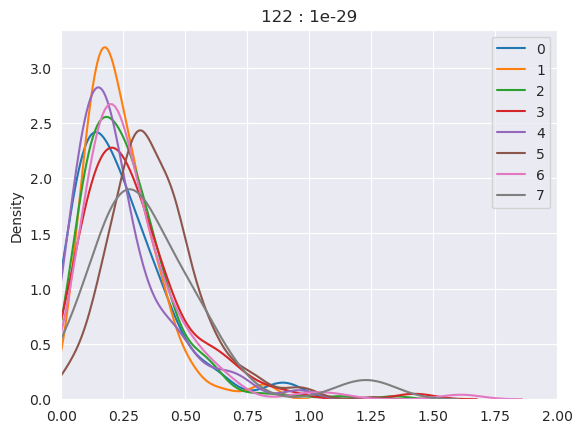

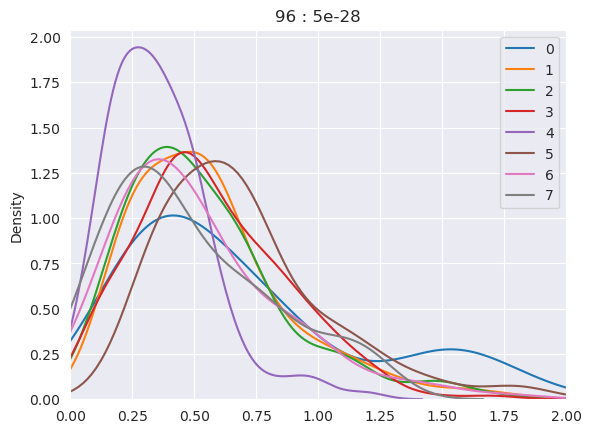

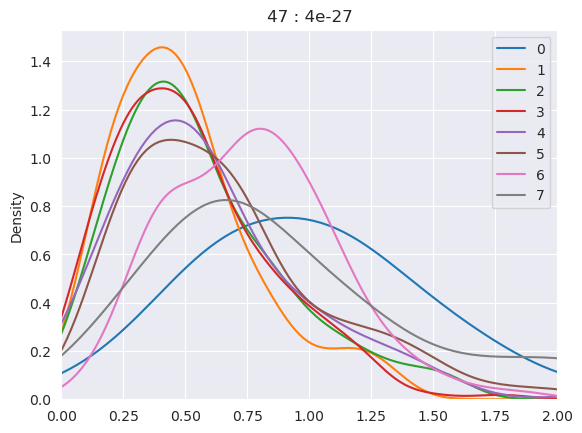

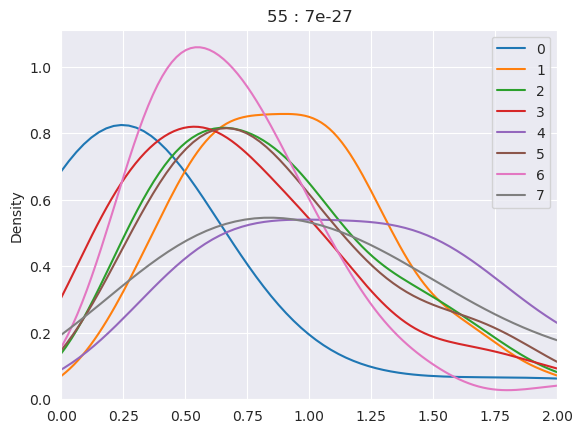

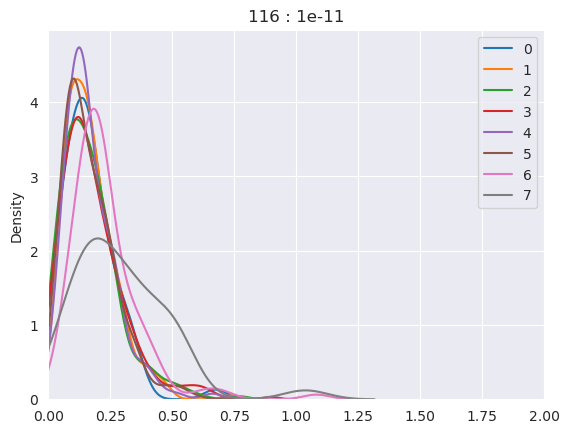

In [96]:
# 5 worst features:
plot_feature_distributions(np.argsort(p_values)[-5:])

# Part 3

XGBoost

In [104]:
import xgboost as xgb

/local/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [134]:
dtrain = xgb.DMatrix(data=train_data, label=train_targets)
dtest = xgb.DMatrix(data=test_data, label=test_targets)

In [147]:
param = {'objective': 'multi:softmax',
         'num_class': MyDataset.NUMBER_OF_CLASSES,
         'eval_metric': ['merror', 'mlogloss']}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-merror:0.42657	eval-mlogloss:1.67641	train-merror:0.00897	train-mlogloss:1.17382
[1]	eval-merror:0.44056	eval-mlogloss:1.52765	train-merror:0.00489	train-mlogloss:0.82239
[2]	eval-merror:0.43357	eval-mlogloss:1.43482	train-merror:0.00163	train-mlogloss:0.59911
[3]	eval-merror:0.43357	eval-mlogloss:1.35365	train-merror:0.00000	train-mlogloss:0.44711
[4]	eval-merror:0.41259	eval-mlogloss:1.30954	train-merror:0.00000	train-mlogloss:0.33791
[5]	eval-merror:0.39161	eval-mlogloss:1.27291	train-merror:0.00000	train-mlogloss:0.25801
[6]	eval-merror:0.39860	eval-mlogloss:1.24966	train-merror:0.00000	train-mlogloss:0.19850
[7]	eval-merror:0.39161	eval-mlogloss:1.22053	train-merror:0.00000	train-mlogloss:0.15395
[8]	eval-merror:0.37762	eval-mlogloss:1.21883	train-merror:0.00000	train-mlogloss:0.12048
[9]	eval-merror:0.37762	eval-mlogloss:1.20809	train-merror:0.00000	train-mlogloss:0.09511
[10]	eval-merror:0.35664	eval-mlogloss:1.20119	train-merror:0.00000	train-mlogloss:0.07607
[11]	eval

Boosting achieves accuracy = 1 - 0.34 = 0.66, which is similar to the accuracy of the neural network (0.64).